In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
'''Data Cleaning'''

# Loading Data
order_payment_dataset = pd.read_csv('./order_payments_dataset.csv')
orders_dataset = pd.read_csv('./orders_dataset.csv')
customer_reviews_dataset = pd.read_csv('./customer_reviews_dataset.csv')
customers_dataset = pd.read_csv('./customers_dataset.csv')
order_items_dataset = pd.read_csv('./order_items_dataset.csv')
products_dataset = pd.read_csv('./products_dataset.csv')
sellers_dataset = pd.read_csv('./sellers_dataset.csv')
geo_dataset = pd.read_csv('./Clean_geodata.csv')
geo_dataset.info()
#link to Clean_geodata: https://drive.google.com/file/d/1ZsuJWBLdsbfWI7GQNgKMZj-a1bh2wDK_/view?usp=sharing

#Dataset Transformation

#1. geo-dataset transdormation:
geo_dataset_seller = geo_dataset #seller zipcode dataset
geo_dataset_seller.rename(columns = {'region1':'region1_seller', 'region2':'region2_seller', 
                              'region3':'region3_seller','latitude':'latitude_seller','longitude':'longitude_seller'}, inplace = True) 
geo_dataset = pd.read_csv('./Clean_geodata.csv')
geo_dataset_consumer = geo_dataset #consumer zipcode dataset
geo_dataset_consumer.rename(columns = {'region1':'region1_con', 'region2':'region2_con', 
                              'region3':'region3_con','latitude':'latitude_con','longitude':'longitude_con'}, inplace = True) 
#2.seller and consumer zip code transform
sellers_dataset['seller_zip_code_prefix'] = sellers_dataset['seller_zip_code_prefix'].astype(int)
customers_dataset['customer_zip_code_prefix'] = customers_dataset['customer_zip_code_prefix'].astype(int)

# Merge Dataset 
final=order_payment_dataset.merge(orders_dataset,on='order_id',how = 'left')
final=final.merge(customer_reviews_dataset,how = 'left',on='order_id')
final=final.merge(customers_dataset,how = 'left',on='customer_id')
final=final.merge(order_items_dataset,how = 'left',on='order_id')
final=final.merge(products_dataset,how = 'left',on='product_id')
final=final.merge(sellers_dataset,how = 'left',on='seller_id')
final=final.merge(geo_dataset_seller,how = 'left',left_on='seller_zip_code_prefix',right_on='postcode')
final=final.merge(geo_dataset_consumer,how = 'left',left_on='customer_zip_code_prefix',right_on='postcode')
#print(final.shape)
#final.isnull().sum()

#genertate sell-con Euclidean_dist

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

final['Eucl'] = [haversine(final.longitude_seller[i],final.latitude_seller[i],final.longitude_con[i],final.latitude_con[i]) for i in range(len(final))]

# Extract survey review data
survey_review_data = final[['order_id','survey_score','survey_review_title','survey_review_content']]
final = final.drop(['survey_review_title','survey_review_content','postcode_x','postcode_y'],axis=1)
#drop null values: clean dataset, good for analysis
final.dropna(inplace=True)

# Clean time variable
final['order_approved_at'] = pd.to_datetime(final['order_approved_at'])
final['order_customer_delivery_date'] = pd.to_datetime(final['order_customer_delivery_date'])
final['shipping_limit_date'] = pd.to_datetime(final['shipping_limit_date'])
final['order_estimated_delivery_date'] = pd.to_datetime(final['order_estimated_delivery_date'])

final['days']=(final['order_customer_delivery_date'].subtract(final['order_approved_at'])).dt.total_seconds() / (3600 * 24)
final['shipping_limit_days']=(final['shipping_limit_date'].subtract(final['order_approved_at'])).dt.total_seconds() / (3600 * 24)
final['estimated_days']=(final['order_estimated_delivery_date'].subtract(final['order_approved_at'])).dt.total_seconds() / (3600 * 24)
# a limit for sellers to send their products to the logistics
#negative values means delivered before the order [they are outliers, should be deleted]
final = final[final['days'].notna()]
final['delivery_state']=(final['order_estimated_delivery_date']).subtract(final['order_customer_delivery_date']).dt.total_seconds() / (3600 * 24)
#negative: delayed, positive: pre deliverd

#drop null values: clean dataset
final.dropna(inplace=True)

# aggregate product information
order_mass = final[['order_id','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]
order_mass['product_mass'] = order_mass['product_length_cm'] * order_mass['product_height_cm'] * order_mass['product_width_cm']
order_mass = order_mass[['order_id','product_mass','product_weight_g']]
order_mass = order_mass.groupby('order_id')['product_mass','product_weight_g'].sum()
order_mass = order_mass.rename(columns={"order_id": "order_id", "product_mass": "order_mass", "product_weight_g": "order_weight_g"})
final=final.merge(order_mass,how = 'left',on='order_id')

# Clean distance between sellers and customers
final['distance']= 0

for i in range(final.shape[0]):
    if final['region3_seller'][i]==final['region3_con'][i]:
        final['distance'][i]=1
    elif final['region2_seller'][i]==final['region2_con'][i]:
        final['distance'][i]=2
    elif final['region1_seller'][i]==final['region1_con'][i]:
        final['distance'][i]=3
    else: 
        final['distance'][i]=4

# 1: same region 3
# 2: same region 2, not same region 3
# 3: same region 1, not same region 2
# 4: not same region 1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23839 entries, 0 to 23838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   postcode   23839 non-null  int64  
 1   region1    23839 non-null  object 
 2   region2    23839 non-null  object 
 3   region3    23839 non-null  object 
 4   latitude   23839 non-null  float64
 5   longitude  23839 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

In [3]:
# Add a new column "Category" to classified products into 10 categories
baby=['bebes','brinquedos','fraldas_higiene','fashion_roupa_infanto_juvenil']
commerce=['agro_industria_e_comercio','industria_comercio_e_negocios']
food_drinks=['la_cuisine','bebidas','alimentos','market_place','alimentos_bebidas']
fashion=['flores','livros_importados','fashion_roupa_feminina','fashion_esporte','fashion_underwear_e_moda_praia','fashion_roupa_masculina','malas_acessorios','relogios_presentes','fashion_calcados','fashion_bolsas_e_acessorios']
home_and_office=['utilidades_domesticas','casa_conforto','artigos_de_natal','artigos_de_festas','casa_conforto_2','portateis_casa_forno_e_cafe','papelaria','pet_shop','construcao_ferramentas_construcao','construcao_ferramentas_ferramentas','ferramentas_jardim','construcao_ferramentas_jardim','casa_construcao','construcao_ferramentas_iluminacao','construcao_ferramentas_seguranca','sinalizacao_e_seguranca','seguros_e_servicos']
sport_and_entertainment=['musica','cine_foto','artes_e_artesanato','cool_stuff','livros_importados','livros_interesse_geral','artes','dvds_blu_ray','cds_dvds_musicais','instrumentos_musicais','esporte_lazer']
furniture=['cama_mesa_banho','moveis_cozinha_area_de_servico_jantar_e_jardim','moveis_decoracao','moveis_escritorio','moveis_colchao_e_estofado','moveis_sala','moveis_quarto']
auto=['automotivo']
beauty=['beleza_saude','perfumaria']
electric_appliance=['informatica_acessorios','telefonia','tablets_impressao_imagem','telefonia_fixa','eletroportateis','consoles_games','audio','climatizacao','eletronicos','eletrodomesticos','livros_tecnicos','pcs','eletrodomesticos_2']

Category = []
NaN = np.nan
final['Category']=NaN
i = 0
for c in final['product_category_name']:
    for x in baby: 
        if c == x: 
             #  Category.append('Baby')
            final.Category.iloc[i]='Baby'
    for x in commerce:
        if c == x:
            final.Category.iloc[i]='Commerce'
    for x in food_drinks:
        if c == x:
            final.Category.iloc[i]='Food_drinks'
    for x in fashion:
        if c == x:
            final.Category.iloc[i]='Fashion'
    for x in home_and_office:
        if c == x:
            final.Category.iloc[i]='Home_and_office'
    for x in sport_and_entertainment:
        if c == x:
            final.Category.iloc[i]='Sports_and_entertainment'
    for x in furniture:
        if c == x:
            final.Category.iloc[i]='Furniture'
    for x in auto:
        if c == x:
            final.Category.iloc[i]='Auto'
    for x in beauty:
        if c == x:
            final.Category.iloc[i]='Beauty'
    for x in electric_appliance:
        if c == x:
            final.Category.iloc[i]='Electric_appliance'
    i = i+1


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
# add new column of order times
count = final['customer_id'].value_counts()
order_num = pd.DataFrame({'customer_id':count.index, 'order_times':count.values})
order_num['binary_order_times'] = [0 if x == '1' else 1 for x in order_num['order_times']]
order_num.head(2)
final=final.merge(order_num, how ='left', on='customer_id')
final.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_carrier_delivery_date,...,days,shipping_limit_days,estimated_days,delivery_state,order_mass,order_weight_g,distance,Category,order_times,binary_order_times
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,...,13.806736,7.0,26.072813,12.266076,7803.0,800.0,4,Home_and_office,1,1
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,...,3.384155,6.0,19.528495,16.144340,1056.0,150.0,1,Auto,1,1


In [4]:
final['year']=final['order_approved_at'].dt.year

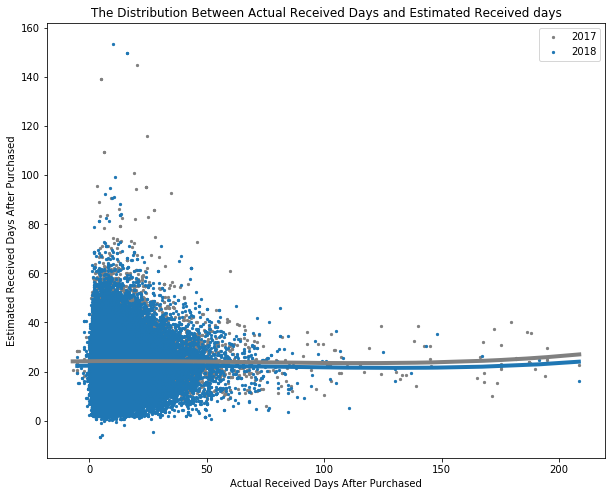

In [21]:
days_2017=final[final['year']==2017]['days'].tolist()
days_2018=final[final['year']==2018]['days'].tolist()
days_2017.sort(key=float)
days_2018.sort(key=float)
estimated_days_2017=final[final['year']==2017]['estimated_days'].tolist()
estimated_days_2018=final[final['year']==2018]['estimated_days'].tolist()

# lineStart = final.days.min() 
# lineEnd = final.days.max()  

# plt.scatter(days,estimated_days)
# plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
# plt.xlabel('Actual received days after purchased')
# plt.ylabel('Estimated received days after purchased')
# plt.show()

parameter_2017 = np.polyfit(days_2017, estimated_days_2017, 3)
parameter_2018 = np.polyfit(days_2018, estimated_days_2018, 3)
# y2 = parameter[0] * days ** 3 + parameter[1] * days ** 2 + parameter[2] * days + parameter[3]
# plt.scatter(days, estimated_days)
# plt.plot(days, y2, color='g')
# plt.show()


p = np.poly1d(parameter_2017)
plt.figure(figsize=(10,8))
g2017=plt.scatter(days_2017, estimated_days_2017, marker='o', s=5.0,color='gray')
plt.plot(days_2017, p(days_2017), color='gray', linewidth=4)

p = np.poly1d(parameter_2018)

g2018=plt.scatter(days_2018, estimated_days_2018, marker='o', s=5.0,color='tab:blue')
plt.plot(days_2018, p(days_2018), color='tab:blue', linewidth=4)
plt.legend(handles=[g2017, g2018], labels=['2017', '2018'])
plt.xlabel('Actual Received Days After Purchased')
plt.ylabel('Estimated Received Days After Purchased')
plt.title('The Distribution Between Actual Received Days and Estimated Received days')

plt.show()


In [60]:
# days=final['days'].tolist()
# days.sort(key=float)
# estimated_days=final['estimated_days'].tolist()

# plt.figure(figsize=(10,8))
# sns.regplot(days, estimated_days)

In [6]:
#final=final.merge(customer_reviews_dataset, how ='left', on='order_id')
final.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_carrier_delivery_date,...,days,shipping_limit_days,estimated_days,delivery_state,order_mass,order_weight_g,distance,Category,order_times,binary_order_times
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,...,13.806736,7.0,26.072813,12.266076,7803.0,800.0,4,Home_and_office,1,1
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,...,3.384155,6.0,19.528495,16.144340,1056.0,150.0,1,Auto,1,1


In [62]:
# final=final.merge(customer_reviews_dataset, how ='left', on='order_id')

# total = final['survey_score_y'].value_counts().tolist()
# one = final[final['order_times']==1]['survey_score_y'].value_counts().tolist()
# more = final[final['order_times']>1]['survey_score_y'].value_counts().tolist()
# print(total)
# print(one)
# print(more)

# sum_total = sum(total)
# sum_one = sum(one)
# sum_more = sum(more)
# total_per = [100*x / sum_total for x in total]
# one_per = [100*x / sum_one for x in one]
# more_per = [100*x / sum_more for x in more]

In [63]:
# plt.plot([1,2,3,4,5],total_per)
# plt.plot([1,2,3,4,5],one_per)
# plt.plot([1,2,3,4,5],more_per)
# plt.legend(['total','one','more'])
# plt.xlabel('Survey Score')
# plt.ylabel('Percentage')
# plt.title('The Distribution of the Score by Customers Order Once v.s. Customers Order One Time v.s. Total')

In [4]:
# feature&labels

final_regression= final.drop(['order_id','payment_sequential','payment_type','payment_installments','customer_id', 'order_status','order_purchase_timestamp', 'order_approved_at','order_carrier_delivery_date', 'order_customer_delivery_date','order_estimated_delivery_date', 'review_id','survey_score','survey_send_date', 'survey_completion_date', 'customer_unique_id','customer_zip_code_prefix', 'customer_city', 'customer_state','order_item_id', 'product_id', 'seller_id', 'product_category_name','product_name_lenght', 'product_description_lenght','product_photos_qty', 'product_weight_g', 'product_length_cm','product_height_cm', 'product_width_cm', 'seller_zip_code_prefix','seller_city', 'seller_state', 'region1_seller', 'region2_seller','region3_seller', 'region1_con', 'region2_con', 'region3_con','shipping_limit_date','latitude_seller','longitude_seller','latitude_con','longitude_con','delivery_state','Category'],axis=1)

features, label = final_regression.drop(['days'], axis=1), final_regression['days']
print(f"feature columns: \n{features.columns}\n")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=30)
X_train2 = X_train.drop(['estimated_days'], axis=1)
X_test2 = X_test.drop(['estimated_days'], axis=1)

##ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
regr = ExtraTreesRegressor()
regr.fit(X_train2, y_train)
ypred = regr.predict(X_test2)

X_test['pre_days'] = ypred
X_test['days'] = y_test
result = X_test.drop(['payment_value','price','freight_value','shipping_limit_days','order_mass','order_weight_g','distance'],axis=1)

result['estimated_days'] = result['estimated_days'].add(.5).round()
result['pre_days'] = result['pre_days'].add(.5).round()
result['days'] = result['days'].add(.5).round()

#comparation
result['better'] = 0
result.index.tolist()


for i in result.index.tolist():
    if result['pre_days'][i] <= result['days'][i] and result['pre_days'][i] > result['estimated_days'][i]:
        result['better'][i] = 1
    
    elif result['pre_days'][i] >= result['days'][i] and result['pre_days'][i] < result['estimated_days'][i]:
        result['better'][i] = 1
        
    elif result['pre_days'][i] >= result['days'][i] and result['estimated_days'] [i] < result['days'][i]:
        result['better'][i] = 1
        
    elif result['pre_days'][i] == result['estimated_days'][i]:
        result['better'][i] = 2

#better?
result_filtered = result[result['better'] < 2] 

#accurate?
result['accurate_pre'] = 0
result.index.tolist()

for i in result.index.tolist():
    if result['pre_days'][i] == result['days'][i]:
        result['accurate_pre'][i] = 1

result['accurate_exp'] = 0
result.index.tolist()

for i in result.index.tolist():
    if result['estimated_days'][i] == result['days'][i]:
        result['accurate_exp'][i] = 1
        
display(result.head(20))
print(result['accurate_pre'].value_counts(),'1:pre is accurate,0:pre is not acc')
print(result['accurate_exp'].value_counts(),'1:exp is accurate,0:exp is not acc')
print(result_filtered['better'].value_counts(),'1:prediction is better,0:expected is better')
print('proportion of 1',sum(result_filtered['better'])/result_filtered.shape[0])


feature columns: 
Index(['payment_value', 'price', 'freight_value', 'Eucl',
       'shipping_limit_days', 'estimated_days', 'order_mass', 'order_weight_g',
       'distance'],
      dtype='object')



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,Eucl,estimated_days,pre_days,days,better,accurate_pre,accurate_exp
81576,371.860350,22.0,11.0,5.0,1,0,0
93075,816.399684,21.0,11.0,12.0,0,0,0
12110,1009.528584,26.0,7.0,7.0,1,1,0
99057,734.199506,23.0,14.0,5.0,1,0,0
50779,3184.634332,46.0,23.0,19.0,1,0,0
77989,1446.609525,40.0,23.0,13.0,1,0,0
94593,255.830694,38.0,13.0,17.0,0,0,0
56084,143.736180,23.0,9.0,12.0,0,0,0
52157,117.716922,15.0,6.0,3.0,1,0,0
11655,520.488856,28.0,16.0,10.0,1,0,0


0    17278
1     5486
Name: accurate_pre, dtype: int64 1:pre is accurate,0:pre is not acc
0    22421
1      343
Name: accurate_exp, dtype: int64 1:exp is accurate,0:exp is not acc
1    15854
0     6618
Name: better, dtype: int64 1:prediction is better,0:expected is better
proportion of 1 0.705500177999288


In [ ]:
g = plot_learning_curve(et.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

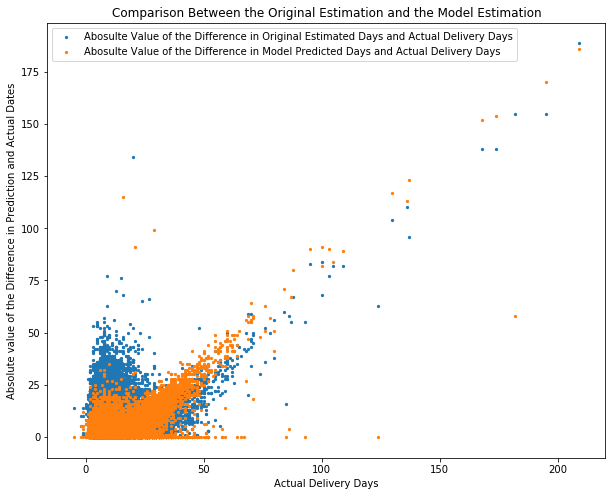

In [80]:
days=result['days']
preday_actual=result['preday_actual']=result['pre_days']-result['days']
result.head(2)
estimated_actual=result['estimated_actual']=result['estimated_days']-result['days']
result.head(2)

preact=result['preday_actual'].abs()
estiact=result['estimated_actual'].abs()

# preday_actual_=result[result['year']==2017]['preday_actual'].tolist()

# estimate_actual=result[result['year']==2018]['preday_actual'].tolist()
# preday_actual_2017.sort(key=float)
# preday_actual_2018.sort(key=float)
# estimated_actual_2017=result[result['year']==2017]['estimated_actual'].tolist()
# estimated_actual_2018=result[result['year']==2018]['estimated_actual'].tolist()

# parameter_2017 = np.polyfit(preday_actual_2017, estimated_actual_2017, 3)
# parameter_2018 = np.polyfit(preday_actual_2018, estimated_actual_2018, 3)

# p = np.poly1d(parameter_2017)
# plt.figure(figsize=(10,8))
# g2017=plt.scatter(preday_actual_2017, estimated_actual_2017, marker='o', s=5.0,color='gray')
# plt.plot(days_2017, p(days_2017), color='gray', linewidth=4)

# p = np.poly1d(parameter_2018)
# g2018=plt.scatter(preday_actual_2018, estimated_actual_2018, marker='o', s=5.0,color='coral')
# plt.plot(days_2018, p(days_2018), color='coral', linewidth=4)

# plt.legend(handles=[g2017, g2018], labels=['2017', '2018'])
# plt.xlabel('our prediction-actual days')
# plt.ylabel('their prediction-actual days')
# plt.title('The Distribution Between Actual Received Days and Model Predicted Received days')


plt.figure(figsize=(10,8))
est = plt.scatter(days,estiact, marker='o', s=5.0)
pre = plt.scatter(days,preact, marker='o', s=5.0)
plt.legend(handles=[est, pre], labels=['Abosulte Value of the Difference in Original Estimated Days and Actual Delivery Days', 'Abosulte Value of the Difference in Model Predicted Days and Actual Delivery Days'])
plt.xlabel('Actual Delivery Days')
plt.ylabel('Absolute value of the Difference in Prediction and Actual Dates')
plt.title('Comparison Between the Original Estimation and the Model Estimation')
plt.show()

In [33]:
result[result['days']==21]['pre_days']
# days_2017=final[final['year']==2017]['days']
result.head(2)

,Eucl,estimated_days,year,pre_days,days,better,accurate_pre,accurate_exp,preday_actual,estimated_actual
81576,371.860350,22.0,2018,8.0,5.0,1,0,0,3.0,17.0
93075,816.399684,21.0,2018,11.0,12.0,0,0,0,-1.0,9.0


In [5]:
'''classification'''
#Dataset for Analysis
final2= final.drop(['order_id','payment_sequential','payment_type','payment_installments','customer_id', 'order_status','order_purchase_timestamp', 'order_approved_at','order_carrier_delivery_date', 
                    'order_customer_delivery_date','order_estimated_delivery_date', 'review_id','survey_score','survey_send_date', 'survey_completion_date', 'customer_unique_id',
                    'customer_zip_code_prefix', 'customer_city', 'customer_state','order_item_id', 'product_id', 'seller_id', 'product_category_name',
                    'product_name_lenght', 'product_description_lenght',
                    'product_photos_qty', 'product_weight_g', 'product_length_cm',
                    'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
                    'seller_city', 'seller_state', 'region1_seller', 'region2_seller',
                    'region3_seller', 'region1_con', 'region2_con', 'region3_con','shipping_limit_date','latitude_seller','longitude_seller','latitude_con','latitude_con'],axis=1)

# feature&labels
final_num=final2._get_numeric_data()
bins = [-np.inf,0,5,10,30,np.inf]
final_num['group'] = pd.cut(final_num['days'].values, bins,labels=[1,2,3,4,5])

## devide features and label
features, label = final_num.drop(["group",'days','delivery_state'], axis=1), final_num['group']
print(f"feature columns: \n{features.columns}\n")

## split train dataset and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=30)

##Decision tree classifier
## find best para
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
param_grid = {'max_depth':[3,5,7,11,100],'ccp_alpha': [0,0.0001]}

dt_model = DecisionTreeClassifier(random_state=10)
dt_model_grid = GridSearchCV (dt_model, param_grid, cv=10)
dt_model_grid.fit (X_train, y_train)

## train model
dt_model_tuned = dt_model_grid.best_estimator_
test_preds = dt_model_tuned.predict(X_test)
train_preds = dt_model_tuned.predict(X_train)
print (dt_model_grid.best_params_)
print ("Train accuracy:", dt_model_tuned.score(X_train,y_train))
print ("Test accuracy:", dt_model_tuned.score(X_test,y_test))

## give out report
from sklearn.metrics import classification_report
print(classification_report (y_test, test_preds))

## show the confusion metrix
from sklearn.metrics import confusion_matrix

cm_dt = confusion_matrix (y_test, test_preds)
print ("Confusion matrix: \n", cm_dt)

#visualization
from sklearn import tree
import graphviz 
import os
feature_names = list(X_test.columns)
class_names = ['1', '2', '3','4','5','6']
'''
Write your code below
'''
dot_data = tree.export_graphviz(dt_model_tuned, out_file=None,feature_names=feature_names,\
                                class_names=class_names, filled=True,\
                                rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

##Random Forest Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier

#set parameters
param_grid_rf={'n_estimators': [5,7,9,11],'max_depth': [11,50,100,200,300],'min_samples_leaf': [50,100],'ccp_alpha':[0, 0.0001]}

#build and train model
RF_model= RandomForestClassifier(random_state=30)
RF_grid= GridSearchCV(RF_model, param_grid_rf)
RF_grid.fit(X_train,y_train)

#results
print ('best parameter:',RF_grid.best_params_)
print ('best score:',RF_grid.best_score_,end='\n\n')

#build the best model
RF_model_tuned = RF_grid.best_estimator_
RF_test_preds = RF_model_tuned.predict(X_test)
RF_train_preds = RF_model_tuned.predict(X_train)

#accuracy
print ("Train accuracy:", RF_model_tuned.score(X_train,y_train))
print ("Test accuracy:", RF_model_tuned.score(X_test,y_test))

## give out report
from sklearn.metrics import classification_report

print(classification_report (y_test, RF_test_preds))

## show the confusion metrix
from sklearn.metrics import confusion_matrix

cm_dt = confusion_matrix (y_test, RF_test_preds)
print ("Confusion matrix: \n", cm_dt)


feature columns: 
Index(['payment_value', 'price', 'freight_value', 'longitude_con', 'Eucl',
       'shipping_limit_days', 'estimated_days', 'order_mass', 'order_weight_g',
       'distance'],
      dtype='object')

{'ccp_alpha': 0, 'max_depth': 11}
Train accuracy: 0.6309402216291611
Test accuracy: 0.5901423299947285
              precision    recall  f1-score   support

           1       0.67      0.43      0.52        14
           2       0.60      0.60      0.60      3637
           3       0.51      0.48      0.49      8030
           4       0.63      0.73      0.68     10090
           5       0.55      0.03      0.06       993

    accuracy                           0.59     22764
   macro avg       0.59      0.45      0.47     22764
weighted avg       0.58      0.59      0.57     22764

Confusion matrix: 
 [[   6    5    2    1    0]
 [   2 2165 1140  329    1]
 [   1 1097 3823 3106    3]
 [   0  311 2349 7407   23]
 [   0   12  124  824   33]]
best parameter: {'ccp_alpha': 0

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pip install wordcloud

In [ ]:
'''Data Description'''
df_order_by_category=final[['product_id','Category']].groupby('Category').count()
df_order_by_category.rename(columns={'product_id':'product_count'},inplace=True)
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw=dict(aspect="equal"))

Name = list(df_order_by_category.index)

data = list(df_order_by_category.product_count)

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, textprops={'fontsize': 10})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(Name[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Market share of our dataset",y=1.08)

plt.show()

## --Graph 2: show the customer review (title/contents) key words of orders-------------
# import basic

import os
from os import path
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


# create txt for customer review title & contents
import csv
survey_review_data.to_csv('survey_review_data.csv')

review_contents = pd.DataFrame(survey_review_data['survey_review_content'])
review_contents.dropna(inplace=True)

review_title = pd.DataFrame(survey_review_data['survey_review_title'])
review_title.dropna(inplace=True)

review_title.to_csv('review_title.txt', index=False)
review_contents.to_csv('review_contents.txt', index=False)

text_title = open("review_title.txt",encoding='utf8').read()
text_title = text_title.replace('\n',"").replace("\u3000","")

text_contents = open("review_contents.txt",encoding='utf8').read()
text_contents = text_title.replace('\n',"").replace("\u3000","")

# create word cloud
mask = np.array(Image.open("Brazil-flag.png"))
wordcloud_contents = WordCloud(background_color="white", max_words=1000, mask=mask).generate(text_contents)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud_contents.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("contents_flag", format="png")
plt.show()


wordcloud_title = WordCloud(background_color="white", max_words=1000, mask=mask).generate(text_title)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud_title.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("title_flag", format="png")
plt.show()

#reference: https://www.datacamp.com/community/tutorials/wordcloud-python

## --Graph 3: order payment method-------------
order_payment_dataset = pd.read_csv('./order_payments_dataset.csv')
order_payment_dataset.describe()
payment_type=order_payment_dataset.groupby('payment_type').count()
payment_type.rename(columns={'order_id':'Frequency'},inplace=True)
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.barplot(x=list(payment_type.index), y='Frequency', data=payment_type)
### credit card is the most frequently used method to pay online

## --Graph 4: measuring the selling situation-------------
orders_dataset = pd.read_csv('./orders_dataset.csv')
orders_dataset['year']=orders_dataset['order_purchase_timestamp'].apply(lambda x: x[:4])
orders_dataset['month']=orders_dataset['order_purchase_timestamp'].apply(lambda x: x[5:7])
sale_month_year=orders_dataset.groupby(['year','month']).count()
sale_month_year.rename(columns={'order_id':'Frequency'},inplace=True)
sale_month_year=sale_month_year['Frequency']
sale_month_year.plot.bar()
# it has a increase tendency and Nov, 2017 is the month with most sales. 


## --Graph 4: 雷达图 showing the feature of each Category-------------
pro_describ=final.groupby('Category').mean()
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')

featurelist=list(pro_describ.index)
Category=list(pro_describ.columns)


for i in range(len(Category)):
    # 构造数据
    values = list(pro_describ[Category[i]])
    feature = featurelist
    N = len(values)
    # 设置雷达图的角度，用于平分切开一个圆面
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    values=np.concatenate((values,[values[0]]))
    angles=np.concatenate((angles,[angles[0]]))